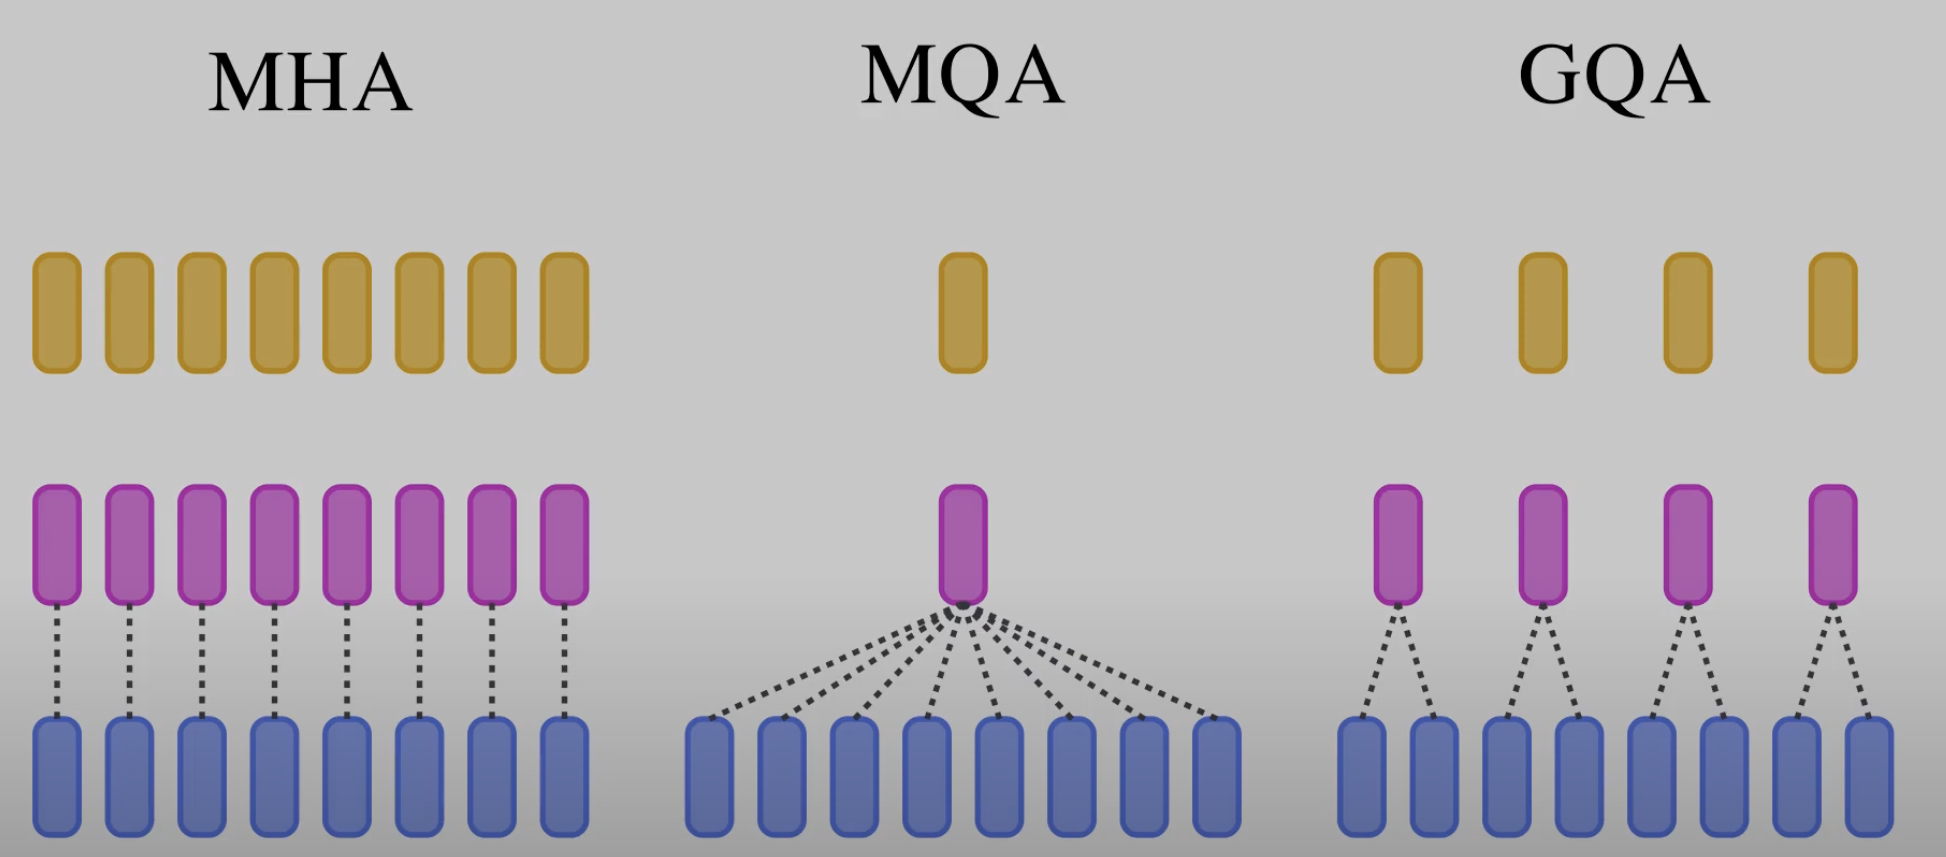

In [156]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoConfig

from attrdict import AttrDict

In [2]:
model_id = 'google-bert/bert-base-uncased'
config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
config, tokenizer

(BertConfig {
   "_name_or_path": "google-bert/bert-base-uncased",
   "architectures": [
     "BertForMaskedLM"
   ],
   "attention_probs_dropout_prob": 0.1,
   "classifier_dropout": null,
   "gradient_checkpointing": false,
   "hidden_act": "gelu",
   "hidden_dropout_prob": 0.1,
   "hidden_size": 768,
   "initializer_range": 0.02,
   "intermediate_size": 3072,
   "layer_norm_eps": 1e-12,
   "max_position_embeddings": 512,
   "model_type": "bert",
   "num_attention_heads": 12,
   "num_hidden_layers": 12,
   "pad_token_id": 0,
   "position_embedding_type": "absolute",
   "transformers_version": "4.42.4",
   "type_vocab_size": 2,
   "use_cache": true,
   "vocab_size": 30522
 },
 BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenizatio

In [116]:
config = {
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": None,
  "gradient_checkpointing": False,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_kv_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": True,
  "vocab_size": 30522,
  "bias":False,
}
config = AttrDict(config)
config

AttrDict({'_name_or_path': 'google-bert/bert-base-uncased', 'architectures': ['BertForMaskedLM'], 'attention_probs_dropout_prob': 0.1, 'classifier_dropout': None, 'gradient_checkpointing': False, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'layer_norm_eps': 1e-12, 'max_position_embeddings': 512, 'model_type': 'bert', 'num_attention_heads': 8, 'num_kv_heads': 4, 'num_hidden_layers': 12, 'pad_token_id': 0, 'position_embedding_type': 'absolute', 'transformers_version': '4.42.4', 'type_vocab_size': 2, 'use_cache': True, 'vocab_size': 30522, 'bias': False})

In [117]:
class Embedding(nn.Module):
    def __init__(self, config):
        super(Embedding, self).__init__()
        
        self.embedding = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.pos = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        
    def forward(self, input_ids, token_type_ids, attention_mask): # , input_ids, token_type_ids = None, attention_mask = None
        
        word_embedding = self.embedding(input_ids)
        
        return word_embedding

In [118]:
embedding = Embedding(config)
embedding

Embedding(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (pos): Embedding(512, 768)
)

In [195]:
text = '''Multi-query attention (MQA), which only
uses a single key-value head, drastically
speeds up decoder inference. However, MQA
can lead to quality degradation, and moreover
it may not be desirable to train a separate
model just for faster inference. We (1) propose
a recipe for uptraining existing multi-head language model checkpoints into models with
MQA using 5% of original pre-training compute, and (2) introduce grouped-query attention (GQA), a generalization of multi-query attention which uses an intermediate (more than
one, less than number of query heads) number
of key-value heads. We show that uptrained
GQA achieves quality close to multi-head attention with comparable speed to MQA. Autoregressive decoder inference is a severe bottleneck for Transformer models due to the memory
bandwidth overhead from loading decoder weights
and all attention keys and values at every decoding step (Shazeer, 2019; Pope et al., 2022; de Jong
et al., 2022). The memory bandwidth from loading
keys and values can be sharply reduced through
multi-query attention (Shazeer, 2019), which uses
multiple query heads but single key and value
heads.
However, multi-query attention (MQA) can lead
to quality degradation and training instability, and
it may not be feasible to train separate models
optimized for quality and inference. Moreover,
while some language models already use multiquery attention, such as PaLM (Chowdhery et al.,
2022), many do not, including publicly available
language models such as T5 (Raffel et al., 2020)
and LLaMA (Touvron et al., 2023).
This work contains two contributions for faster
inference with large language models. First, we show that language model checkpoints with multihead attention (MHA) can be uptrained (Komatsuzaki et al., 2022) to use MQA with a small fraction of original training compute. This presents a
cost-effective method to obtain fast multi-query as
well as high-quality MHA checkpoints.
Second, we propose grouped-query attention
(GQA), an interpolation between multi-head and
multi-query attention with single key and value
heads per subgroup of query heads. We show that
uptrained GQA achieves quality close to multihead attention while being almost as fast as multiquery attention.'''
token = tokenizer(text, 
                  return_tensors='pt', 
                  padding='max_length', 
                  truncation=True, 
                  max_length=config.max_position_embeddings)
token['input_ids'].shape, token['attention_mask'].shape, token['token_type_ids'].shape

(torch.Size([1, 512]), torch.Size([1, 512]), torch.Size([1, 512]))

In [196]:
token['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [197]:
word_embdding = embedding(**token)
word_embdding.shape, word_embdding

(torch.Size([1, 512, 768]),
 tensor([[[ 0.3451, -1.5271, -0.8761,  ...,  0.0084,  2.1244,  0.2410],
          [ 0.1367,  0.6524,  2.0277,  ..., -0.3661, -0.9440, -0.2777],
          [ 0.0869,  0.7755, -0.0406,  ...,  0.3673,  1.2147, -0.1804],
          ...,
          [-1.8069,  0.2461, -1.0676,  ..., -0.7766,  0.0196, -1.2258],
          [ 0.5365, -1.1944, -0.6694,  ...,  1.0120,  0.2675, -0.1192],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<EmbeddingBackward0>))

In [198]:
# bs * seq * feature
word_embdding.shape

torch.Size([1, 512, 768])

In [199]:
kv_embed_dim2 = config.hidden_size * (config.num_attention_heads // config.num_kv_heads)
embed_dim = config.hidden_size
query_heads = config.num_attention_heads
kv_heads = config.num_kv_heads
kv_embed_dim = embed_dim * (query_heads // kv_heads)
kv_embed_dim, kv_embed_dim2

(1536, 1536)

In [200]:
config

AttrDict({'_name_or_path': 'google-bert/bert-base-uncased', 'architectures': ['BertForMaskedLM'], 'attention_probs_dropout_prob': 0.1, 'classifier_dropout': None, 'gradient_checkpointing': False, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'layer_norm_eps': 1e-12, 'max_position_embeddings': 512, 'model_type': 'bert', 'num_attention_heads': 8, 'num_kv_heads': 4, 'num_hidden_layers': 12, 'pad_token_id': 0, 'position_embedding_type': 'absolute', 'transformers_version': '4.42.4', 'type_vocab_size': 2, 'use_cache': True, 'vocab_size': 30522, 'bias': False})

In [289]:
class BaseAttention(nn.Module):
    def __init__(self, config):
        super(BaseAttention, self).__init__()
        
        self.num_attention_heads = config.num_attention_heads
        self.num_kv_heads = config.num_kv_heads
        # num_attention_heads = 12
        
        # 64 = 768 / 12
        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads) 
        # 768 = 12 * 64
        self.all_head_size = self.num_attention_heads * \
            self.attention_head_size # = 'hidden_size' : 768
        
        # Self-Attention의 특징량을 작성하는 전결합 층 & mha
        self.ha_query = nn.Linear(config.hidden_size, self.all_head_size)
        self.ha_key = nn.Linear(config.hidden_size, self.all_head_size)
        self.ha_value = nn.Linear(config.hidden_size, self.all_head_size)
        
        # mqa & gqa
        # hidden_size * (kv_heads // query_heads)
        kv_hidden_size = int(config.hidden_size * (config.num_kv_heads / config.num_attention_heads))
        self.qa_key = nn.Linear(config.hidden_size, kv_hidden_size)
        self.qa_value = nn.Linear(config.hidden_size, kv_hidden_size)
        
        # softmax
        self.softmax = nn.Softmax(dim=-1)
        
        # dropout
        self.dropout = nn.Dropout(p=config.attention_probs_dropout_prob)
        
    def change_to_multihead(self, x):
        # batch * pos * feature ->　batch * head_num * pos * pos
        # x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x_newshape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        # print('x shape : {}'.format(x.shape))
        x = x.view(*x_newshape)
        return x.permute(0, 2, 1, 3)
        
    def change_to_multiquery(self, query, key, value):
        # query
        # [1, 256, 384]
        # -> bs * query_head/kv_head * kv_head * seq * feature
        query_new_shape = query.size()[:-1] + (self.num_attention_heads // self.num_kv_heads, self.num_kv_heads, self.attention_head_size)
        query = query.view(*query_new_shape)
        query = query.permute(0, 2, 3, 1, 4)
         
        # key & value 
        # [1, 256, 192]
        kv_feature = int(key.size()[-1] / self.num_kv_heads)
        kv_new_shape = key.size()[:-1] + (self.num_kv_heads, kv_feature) 
        # -> bs * seq * kv_head_num * feature 
        key = key.view(*kv_new_shape)
        key = key.permute(0, 2, 1, 3) # -> bs * kv_head_num * seq * feature
        
        # -> bs * seq * kv_head_num * feature
        value = value.view(*kv_new_shape)
        value = value.permute(0, 2, 1, 3) # -> bs * kv_head_num * seq * feature
        
        return query, key, value
        
    def forward(self, hidden_states, attention_mask, is_casual = None, attention_type='mha'):
        
        if attention_type == 'mha':
            
            mixed_query = self.ha_query(hidden_states)
            mixed_key = self.ha_key(hidden_states)
            mixed_value = self.ha_value(hidden_states)
            
            multi_query = self.change_to_multihead(mixed_query)
            multi_key = self.change_to_multihead(mixed_key)
            multi_value = self.change_to_multihead(mixed_value)
            
            print('hidden_states shape : {}'.format(hidden_states.shape))
            print('mixed_query shape : {}'.format(mixed_query.shape))
            print('multi_query shape : {}'.format(multi_query.shape))
            
        elif attention_type in ['mqa', 'gqa']:
            
            mixed_query = self.ha_query(hidden_states)
            mixed_key = self.qa_key(hidden_states)
            mixed_value = self.qa_value(hidden_states)
            
            print('mixed_query shape : {}'.format(mixed_query.shape))
            print('mixed_key shape : {}'.format(mixed_key.shape))
            print('mixed_value shape : {}'.format(mixed_value.shape))
            
            multi_query, multi_key, multi_value = self.change_to_multiquery(mixed_query, mixed_key, mixed_value)
            
            print('multi_query shape : {}'.format(multi_query.shape))
            print('multi_key shape : {}'.format(multi_key.shape))
            print('multi_value shape : {}'.format(multi_value.shape))
        else:
            raise ValueError(
                f'{attention_type} is not attention_type'
        )
        
        # scaling
        # int(np.sqrt(512 // 8))
        scale = self.num_attention_heads ** 0.5
        print(scale)
        multi_query = multi_query / scale
            
        # query @ key
        matmul = multi_query @ multi_key.transpose(-1, -2)
        print('matmul shape : {}'.format(matmul.shape))

        # to do mask

        # casual
        if is_casual is not None:
            causal_mask_shape = matmul.size()[:1] + matmul.size()[-2:]
            causal_mask = torch.tril(torch.ones((*causal_mask_shape)))
            matmul = matmul.masked_fill(causal_mask == 0, -1e9)
        
        # softmax
        matmul = self.softmax(matmul)
        print('after softmax matmul shape : {}'.format(matmul.shape))

        # dropout
        matmul = self.dropout(matmul)

        # attentionscore @ value
        output = matmul @ multi_value

        # return to hidden_states shape
        output = output.view(hidden_states.size())

        return output, matmul

In [290]:
attention = BaseAttention(config)
attention

BaseAttention(
  (ha_query): Linear(in_features=768, out_features=768, bias=True)
  (ha_key): Linear(in_features=768, out_features=768, bias=True)
  (ha_value): Linear(in_features=768, out_features=768, bias=True)
  (qa_key): Linear(in_features=768, out_features=384, bias=True)
  (qa_value): Linear(in_features=768, out_features=384, bias=True)
  (softmax): Softmax(dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [294]:
print('word_embdding shape : {}'.format(word_embdding.shape))
output, matmul = attention(word_embdding, token['attention_mask'], attention_type='mha')

word_embdding shape : torch.Size([1, 512, 768])
hidden_states shape : torch.Size([1, 512, 768])
mixed_query shape : torch.Size([1, 512, 768])
multi_query shape : torch.Size([1, 8, 512, 96])
2.8284271247461903
matmul shape : torch.Size([1, 8, 512, 512])
after softmax matmul shape : torch.Size([1, 8, 512, 512])


In [279]:
token_ = [tokenizer.decode(token) for token in token['input_ids'][0][:25]]

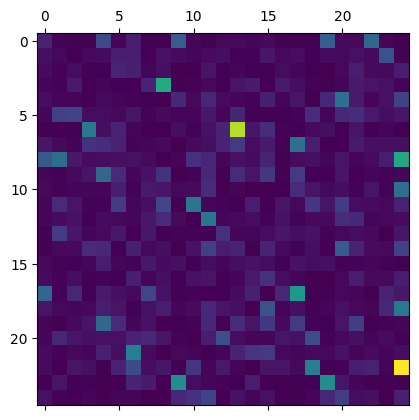

In [295]:
plt.matshow(matmul[0][-1][:25, :25].detach().numpy())

<Figure size 1000x1000 with 0 Axes>

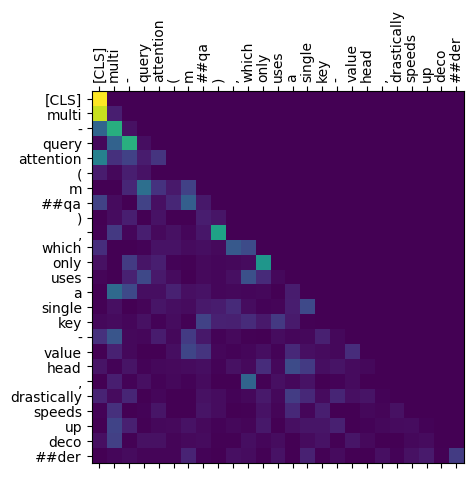

In [282]:
plt.figure(figsize=(10, 10))

plt.matshow(matmul[0][-2][:25, :25].detach().numpy())
plt.xticks(range(0, 25), token_, rotation=90)
plt.yticks(range(0, 25), token_)

plt.show()

<Figure size 1000x1000 with 0 Axes>

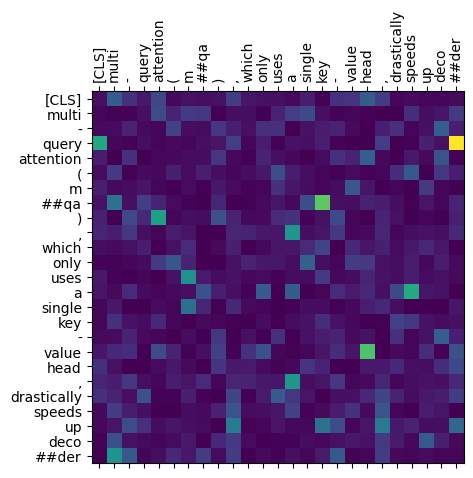

In [293]:
plt.figure(figsize=(10, 10))

plt.matshow(matmul[0][-2][0][:25, :25].detach().numpy())
plt.xticks(range(0, 25), token_, rotation=90)
plt.yticks(range(0, 25), token_)

plt.show()

In [300]:
mask = torch.tril(torch.ones(1, 512, 512))
rearrange(mask, "b n s -> b () () n s").shape

torch.Size([1, 1, 1, 512, 512])

In [297]:
from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from einops import einsum, rearrange
from torch import Tensor, nn

def scaled_dot_product_gqa(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    dropout: float = 0.0,
    scale: Optional[float] = None,
    mask: Optional[Tensor] = None,
    is_causal: Optional[bool] = None,
    need_weights: bool = False,
    average_attn_weights: bool = False,
    force_grouped: bool = False,
):
    """Scaled dot product attention with support for grouped queries.

    Einstein notation:
    - b: batch size
    - n / s: sequence length
    - h: number of heads
    - g: number of groups
    - d: dimension of query/key/value

    Args:
        query: Query tensor of shape (b, n, h, d)
        key: Key tensor of shape (b, s, h, d)
        value: Value tensor of shape (b, s, h, d)
        dropout: Dropout probability (default: 0.0)
        scale: Scale factor for query (default: d_query ** 0.5)
        mask: Mask tensor of shape (b, n, s) or (b, s). If 'ndim == 2', the mask is
            applied to all 'n' rows of the attention matrix. (default: None)
        force_grouped: If True, apply grouped-query attention even if the number of
            heads is equal for query, key, and value. (default: False)

    Returns:
        2-tuple of:
        - Attention output with shape (b, n, h, d)
        - (Optional) Attention weights with shape (b, h, n, s). Only returned if
          'need_weights' is True.
    """
    if (mask is not None) and (is_causal is not None):
        raise ValueError(
            "Only one of 'mask' and 'is_causal' should be provided, but got both."
        )
    elif not query.ndim == key.ndim == value.ndim == 4:
        raise ValueError(
            f"Expected query, key, and value to be 4-dimensional, but got shapes "
            f"{query.shape}, {key.shape}, and {value.shape}."
        )

    # Move sequence length dimension to axis 2.
    # This makes the attention operations below *much* faster.
    query = query.permute(0, 2, 1, 3)
    key = key.permute(0, 2, 1, 3)
    value = value.permute(0, 2, 1, 3)
    # query = rearrange(query, "b n h d -> b h n d")
    # key = rearrange(key, "b s h d -> b h s d")
    #　value = rearrange(value, "b s h d -> b h s d")

    bq, hq, nq, dq = query.shape
    bk, hk, nk, dk = key.shape
    bv, hv, nv, dv = value.shape
    if not (bq == bk == bv and dq == dk == dv):
        raise ValueError(
            "Expected query, key, and value to have the same batch size (dim=0) and "
            f"embedding dimension (dim=3), but got query: {query.shape}, "
            f"key: {key.shape}, and value: {value.shape}."
        )
    elif (hk != hv) or (nk != nv):
        raise ValueError(
            "Expected key and value to have the same size in dimensions 1 and 2, but "
            f"got key: {key.shape} and value: {value.shape}."
        )
    elif hq % hk != 0:
        raise ValueError(
            "Expected query heads to be a multiple of key/value heads, but got "
            f"query: {query.shape} and key/value: {key.shape}."
        )

    if scale is None:
        scale = query.size(-1) ** 0.5
    query = query / scale

    num_head_groups = hq // hk
    # to view query
    # bs * head_num * seq * feature
    # -> bs * (q_heads // kv_heads) * hk * seq * feature
    query = query.view(bq, num_head_groups, hq//num_head_groups, nq, dq)
    # query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)
    
    # query @ key
    # bs * (q_heads // kv_heads) * hk * seq * feature @ bs * kv_heads * seq * feature
    similarity = query.matmul(key.transpose(-1, -2))
    # similarity = einsum(query, key, "b g h n d, b h s d -> b g h n s")
    
    print('hq : {}, hk : {}'.format(hq, hk))
    print('num_head_groups : {}'.format(num_head_groups))
    print('scaled dot product func query shape : {}'.format(query.shape))
    print('scaled dot product func key shape : {}'.format(key.shape))
    print('scaled dot product func similarity shape : {}'.format(similarity.shape))
    
    if is_causal:
        # Mask out the upper triangular portion of the attention matrix. This prevents
        # the model from attending to tokens in the future.
        mask = torch.ones((bq, nq, nk), device=query.device, dtype=torch.bool).tril_()

    if mask is not None:
        # Expand mask to match the shape of the attention matrix.
        # If mask is 2D, assume that it is applied to the key/value sequence dimension.
        # Else if mask is 3D, assume that it is applied to the query/key/value sequence
        # dimension for all attention heads.
        #
        # Users could also provide a 4D mask, which is applied to the query/key/value
        # sequence dimension for each attention head (though I don't have a particular
        # use case in mind for that).
        if mask.ndim == 2:
            mask = rearrange(mask, "b s -> b () () () s")
        elif mask.ndim == 3:
            mask = rearrange(mask, "b n s -> b () () n s")
        # Mask similarity values by setting them to negative infinity.  This guarantees
        # that they will not contribute to the softmax computation below.
        similarity.masked_fill_(~mask, torch.finfo(similarity.dtype).min)

    attention = F.softmax(similarity, dim=-1)
    if dropout > 0.0:
        attention = F.dropout(attention, p=dropout)

    # Apply attention matrix to the value Tensor.
    out = attention @ value
    # out = einsum(attention, value, "b g h n s, b h s d -> b g h n d")
    
    # Move head dimension back to axis 2
    out = out.view(bq, nq, hq, dq)
    # out = rearrange(out, "b g h n d -> b n (h g) d")

    attn_weights: Optional[Tensor] = None
    if need_weights:
        # Move the sequence dimensions back to positions 1, 2.  Move the head dimension
        # to position 3.  This more closely matches the return shape of the attention
        # output: (b, n, h, d).
        attn_weights = rearrange(attention, "b g h n s -> b n s (h g)")
        if average_attn_weights:
            attn_weights = attn_weights.mean(dim=1)

    return out, attn_weights


class MultiheadGQA(nn.Module):
    """Multi-head grouped query attention (GQA) layer.

    Reference:
        "GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints"
        https://arxiv.org/pdf/2305.13245v1.pdf

    GQA is a variant of multihead attention (MHA) that uses fewer write heads
    (key / value) than query heads.  GQA can be viewed as a generalization of
    multi-query attention (MQA), which uses a single write head. GQA and MQA give
    significant speedups over standard MHA in decoder layers, with minimal loss in
    accuracy. In the paper, GQA is shown to be more accurate than MQA, while still
    having a significant speedup over MHA.

    NOTE: The original authors only benchmark GQA by adapting the T5 (XL or XXL) model
    from MHA to GQA.  As a result, they do not mention parameter initialization or
    layer normalization strategies.  I follow the best practices laid out in the
    MAGNETO paper, which improves Transformer performance through better parameter
    initialization and layer norm placement.  See:
        https://arxiv.org/pdf/2210.06423.pdf, Fig. 2
    """

    def __init__(
        self,
        embed_dim: int,
        query_heads: int,
        kv_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        layer_norm: bool = True,
        layer_norm_eps: float = 1e-5,
        gamma_init: float = 1.0,
        device: Optional[Union[torch.device, str]] = None,
        dtype: Optional[torch.dtype] = None,
    ):
        super().__init__()
        self.query_heads = query_heads
        self.kv_heads = kv_heads
        self.dropout = dropout
        self.layer_norm = layer_norm
        self.gamma_init = gamma_init

        if self.query_heads % self.kv_heads != 0:
            raise ValueError(
                f"query_heads ({query_heads}) must be divisible by "
                f"kv_heads ({kv_heads})"
            )
        elif (embed_dim % self.query_heads != 0) or (embed_dim % self.kv_heads != 0):
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by "
                f"query_heads ({query_heads}) and kv_heads ({kv_heads})"
            )

        head_dim = embed_dim // query_heads
        if not head_dim % 8 == 0:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be divisible by 8"
            )
        if not head_dim <= 128:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be <= 128"
            )

        # Query projection layer is the same as in vanilla MHA.
        self.q_proj = nn.Linear(
            embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )
        # Key/value projection layers have a smaller output dimension, so that
        # the we have fewer key/value attention heads after reshaping.
        # 768 // 8 * 4
        # 768 * (1/2)
        # query는 768차원을 8로 나누어서 96차원을 가지고 있는 것이며
        # key는 그룹으로 해서 4개만의 head를 가질 것이기에 각각이 96개의 차원을 가지도록 하려면 여기서 query_head // key_head로 나눈 값으로 들어가야함
        kv_embed_dim = embed_dim * (query_heads // kv_heads)
        self.k_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        self.v_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        
        # Layernorm 
        self.norm: Optional[nn.LayerNorm] = None
        if layer_norm:
            self.norm = nn.LayerNorm(
                embed_dim, eps=layer_norm_eps, device=device, dtype=dtype
            )
        # Grouped attention output will have the same embedding dimension as the
        # key/value Tensors.  So the output projection layer needs to accept the
        # same dimension (kv_embed_dim).
        self.out_proj = nn.Linear(
            embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.q_proj.weight)
        if self.q_proj.bias is not None:
            nn.init.constant_(self.q_proj.bias, 0)
            
        nn.init.xavier_normal_(self.k_proj.weight)
        if self.k_proj.bias is not None:
            nn.init.constant_(self.k_proj.bias, 0)

        # NOTE: We follow the initialization strategy from MAGNETO.  See:
        # https://arxiv.org/pdf/2210.06423.pdf, Fig. 2
        # Gain (self.gamma_init) should be provided as a keyword argument when
        # initializing the larger Transformer model, since it requires knowledge
        # of the number of encoder/decoder layers in the model.

        nn.init.xavier_normal_(self.v_proj.weight, gain=self.gamma_init)
        if self.v_proj.bias is not None:
            nn.init.constant_(self.v_proj.bias, 0)
            
        nn.init.xavier_normal_(self.out_proj.weight, gain=self.gamma_init)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        need_weights: bool = False,
        # TODO
        # attn_mask: Optional[Tensor] = None,
        is_causal: bool = False,
        average_attn_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        # Notation:
        #   b - batch size
        #   n - sequence length
        #   h - number of heads
        #   d - embedding dimension
        #
        # Input shape: (b, n, d)
        q: Tensor = self.q_proj(query)
        k: Tensor = self.k_proj(key)
        v: Tensor = self.v_proj(value)

        print('before rearrange q shape : {}'.format(q.shape))
        print('before rearrange k shape : {}'.format(k.shape))
        print('before rearrange v shape : {}'.format(v.shape))
            
        # Unfold 'd' dimension into 'h' separate attention heads.
        q = rearrange(q, "b n (h d) -> b n h d", h=self.query_heads)
        k = rearrange(k, "b n (h d) -> b n h d", h=self.kv_heads)
        v = rearrange(v, "b n (h d) -> b n h d", h=self.kv_heads)
        
        print('after rearrange q shape : {}'.format(q.shape))
        print('after rearrange k shape : {}'.format(k.shape))
        print('after rearrange v shape : {}'.format(v.shape))
        
        # Apply attention, then fold 'h' attention heads back into 'd'.
        x, attn = scaled_dot_product_gqa(
            query=q,
            key=k,
            value=v,
            # TODO
            # mask=attn_mask,
            is_causal=is_causal,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights,
            force_grouped=False,
        )
        x = rearrange(x, "b n h d -> b n (h d)")

        # NOTE: This is different from 'nn.MultiheadAttention'!  We follow the MAGNETO
        # architecture (https://arxiv.org/pdf/2210.06423.pdf), which applies an extra
        # layer norm before the linear output projection.  The cross-attention layer in
        # the MAGNETO decoder does not include this layer norm, so users have the
        # option to disable it (layer_norm=False).
        if self.layer_norm:
            assert self.norm is not None
            x = self.norm(x)
        # Linear projection on attention outputs.
        x = self.out_proj(x)

        return x, attn

In [248]:
        embed_dim: int,
        query_heads: int,
        kv_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        layer_norm: bool = True,
        layer_norm_eps: float = 1e-5,
        gamma_init: float = 1.0,
        device: Optional[Union[torch.device, str]] = None,
        dtype: Optional[torch.dtype] = None,

SyntaxError: invalid syntax (3086670315.py, line 1)

In [249]:
config

BertConfig {
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [250]:
gqa = MultiheadGQA(embed_dim=config.hidden_size, query_heads=8, kv_heads=4)
gqa

MultiheadGQA(
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (k_proj): Linear(in_features=768, out_features=384, bias=True)
  (v_proj): Linear(in_features=768, out_features=384, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [252]:
x, attn = gqa(word_embdding, word_embdding, word_embdding)
x.shape

before rearrange q shape : torch.Size([1, 512, 768])
before rearrange k shape : torch.Size([1, 512, 384])
before rearrange v shape : torch.Size([1, 512, 384])
after rearrange q shape : torch.Size([1, 512, 8, 96])
after rearrange k shape : torch.Size([1, 512, 4, 96])
after rearrange v shape : torch.Size([1, 512, 4, 96])
hq : 8, hk : 4
num_head_groups : 2
scaled dot product func query shape : torch.Size([1, 2, 4, 512, 96])
scaled dot product func key shape : torch.Size([1, 4, 512, 96])
scaled dot product func similarity shape : torch.Size([1, 2, 4, 512, 512])


torch.Size([1, 512, 768])

In [241]:
512 * 16 * 96

786432

In [242]:
393216 / (786432)

0.5

In [182]:
# rearrange(q, "b n (h d) -> b n h d", h=self.query_heads)
new_x_shape = word_embdding.size()[:-1] + (8, 96)
# rearrange(word_embdding, "1 512 768 -> 1 512 8 96")
word_embdding.view(*new_x_shape).shape

torch.Size([1, 512, 8, 96])

In [210]:
rearrange(test, "b n (h d) -> b n h d", h=4).shape

torch.Size([1, 512, 4, 96])

In [209]:
del b, n

In [208]:
rearrange?

In [316]:
test = torch.randn(1, 2, 4, 512, 96)
test2 = torch.randn(1, 6, 2, 4, 512, 96)
test.shape, test2.shape

(torch.Size([1, 2, 4, 512, 96]), torch.Size([1, 6, 2, 4, 512, 96]))

In [317]:
test.shape, test2.transpose(-1, -2).shape, (test @ test2.transpose(-1, -2)).shape

(torch.Size([1, 2, 4, 512, 96]),
 torch.Size([1, 6, 2, 4, 96, 512]),
 torch.Size([1, 6, 2, 4, 512, 512]))

In [265]:
test @ test2

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [8, 96] but got: [8, 512].

In [255]:
word_embdding.ndim

3

In [197]:
word_embdding.size()[2]

768

In [192]:
768 / 4

192.0

In [193]:
b, n, d

(1, 512, 384)

In [ ]:
        query: Tensor,
        key: Tensor,
        value: Tensor,
        need_weights: bool = False,
        # TODO
        # attn_mask: Optional[Tensor] = None,
        is_causal: bool = False,
        average_attn_weights: bool = False,

In [171]:
8 * 96

768

In [271]:
import torch

# 4차원 텐서 [B1, M1, K, N]
tensor1 = torch.randn(2, 3, 5, 4)

# 5차원 텐서 [B2, M2, P, K, Q]
tensor2 = torch.randn(2, 1, 3, 4, 5)

# 곱셈 수행
result = torch.matmul(tensor1, tensor2)

print("Result shape:", result.shape)  # [B, M1, P, N, Q]

Result shape: torch.Size([2, 2, 3, 5, 5])


In [269]:
2 * 3 * 4 * 5, 2 * 6 * 4 * 5

(120, 240)

In [286]:
x = 8
y = 5
tensor1 = torch.radn(2, 8, 4, 5)
tensor2 = torch.radn(2, 1, x, y, 4)
result = torch.matmul(tensor1, tensor2)
print('result shape : {}'.format(result.shape))

AttributeError: module 'torch' has no attribute 'radn'

In [ ]:
2 8 4 5, 2 1 1 5 4

In [287]:
for x in range(1, 10):
    for y in range(1, 10):
        try:
            tensor1 = torch.randn(2, 8, 4, 5)
            tensor2 = torch.randn(2, 1, x, y, 4) 
            # 1 5 -> 2 2 8 4 4
            # 8 5 -> 2 2 8 4 4
            result = torch.matmul(tensor1, tensor2)
            print('result shape : {}'.format(result.shape))
        except:
            print(x, y)

1 1
1 2
1 3
1 4
result shape : torch.Size([2, 2, 8, 4, 4])
1 6
1 7
1 8
1 9
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 1
8 2
8 3
8 4
result shape : torch.Size([2, 2, 8, 4, 4])
8 6
8 7
8 8
8 9
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


In [393]:
import torch

# 4차원 텐서: [B1, M, K, N]
tensor1 = torch.randn(2, 8, 5, 4)

# 5차원 텐서: [B2, P, K, Q, R]
tensor2 = torch.randn(2, 2, 8, 5, 4)

# 곱셈 수행
# result = torch.matmul(tensor1, tensor2)

print("Result shape:", result.shape)

Result shape: torch.Size([2, 2, 8, 4, 4])


In [389]:
2 8 4 5, 2 1 8 4 5

SyntaxError: invalid syntax (2398690639.py, line 1)

2 8 4 5 와 2 1 8 5 4 일때 matmul을 하면 결과는 2 2 8 4 4 가 된다.

일단 둘의 차원은 4차원과 5차원이다. 5차원 텐서인 2 1 8 5 4를 batch size 기준으로 각각 나눠보면 1 8 5 4가 두 개 생겨진다.

그럼 그럼 이제 두 개의 1 8 5 4 와 2 8 4 5 를 matmul해보자.

브로드캐스팅에 의해 1 8 5 4는 2 8 4 5 를 각각 쪼갠 두 개의 1 8 4 5와 matmul를 진행한다.

자연스레 두 번을 진행했으니 맨처음 차원은 2가 될 것이고 중간은 8 5 4 @ 8 4 5 로 인해 8 4 4가 나오고 두 번 했기에 2 8 4 4 가 된다.

1 8 5 4 와 2 8 4 5 의 결과는 2 8 4 4가 되어지며 이또한 1 8 5 4가 두 개이니 2 8 4 4가 두 개 생긴것이다.

결과적으로 2 2 8 4 4가 생겨진다.

In [395]:
tensor1 = torch.randn(2, 8, 4, 5)
tensor2 = torch.randn(1, 8, 4, 5)


In [396]:
(tensor1 + tensor2).shape

torch.Size([2, 8, 4, 5])

In [279]:
torch.matmul?

In [366]:
tensor1 = torch.randn(2, 2, 2, 4, 16, 32)
tensor2 = torch.randn(2, 4, 16, 32)
tensor1.shape, tensor2.shape

(torch.Size([2, 2, 2, 4, 16, 32]), torch.Size([2, 4, 16, 32]))

In [367]:
result = tensor1 @ tensor2.transpose(-1, -2)
result.shape, result

(torch.Size([2, 2, 2, 4, 16, 16]),
 tensor([[[[[[-4.5023e-01, -3.9570e+00, -4.5601e+00,  ...,  4.1974e+00,
               5.7845e+00,  9.0631e+00],
             [-2.1793e+00, -3.4221e+00, -7.8353e+00,  ...,  9.2503e-01,
              -6.4999e+00,  3.3680e+00],
             [-3.0804e+00,  5.9094e+00,  3.4944e+00,  ..., -4.3865e-02,
               4.2027e+00, -5.0427e-01],
             ...,
             [-5.3790e+00,  1.6053e+00,  7.4832e+00,  ..., -1.3216e+01,
              -7.0196e+00, -2.4514e+00],
             [-1.2930e+00,  1.6137e+00,  1.4994e-01,  ...,  6.3545e+00,
              -2.4665e+00, -6.7981e+00],
             [ 8.8477e-01, -3.8621e+00, -2.0607e+00,  ..., -8.7865e-01,
               2.3989e+00,  2.8798e+00]],
 
            [[-6.2092e+00,  8.1308e-01, -9.4771e-02,  ...,  7.5410e+00,
               6.2210e+00,  2.9670e+00],
             [ 7.2766e-01,  1.0959e-01, -7.7525e+00,  ...,  5.4147e+00,
              -6.7647e+00,  1.2438e+01],
             [-1.9183e+00,  1.0586e+00, 

In [363]:
result1 = tensor1[0] @ tensor2.transpose(-1, -2)
result1.shape

torch.Size([2, 2, 4, 16, 16])

In [364]:
result2 = tensor1[1] @ tensor2.transpose(-1, -2)
result2.shape

torch.Size([2, 2, 4, 16, 16])

In [365]:
result3 = torch.stack([result1, result2])
result3.shape, result3

(torch.Size([2, 2, 2, 4, 16, 16]),
 tensor([[[[[[-3.8362e+00,  2.3707e+00,  1.3054e+01,  ..., -1.8588e+00,
               4.5289e+00,  4.4166e+00],
             [ 1.5814e+00,  1.8793e+00,  2.1678e+00,  ...,  7.6152e+00,
               4.4613e+00,  9.2381e+00],
             [ 5.8145e+00, -4.9300e-01,  6.3383e+00,  ...,  4.1354e+00,
              -2.3479e+00, -9.5770e+00],
             ...,
             [-1.2158e+01,  2.4305e-01,  4.9485e+00,  ..., -9.6934e+00,
               4.0916e+00,  7.8785e+00],
             [-7.7387e+00, -1.6616e+00, -1.7382e+00,  ..., -1.2750e+01,
               2.0753e+00, -2.1343e-01],
             [-3.0215e+00,  1.3136e+00, -2.6245e+00,  ...,  1.8223e+00,
               1.0620e+00,  1.4415e+01]],
 
            [[-8.0021e-01,  2.0852e+00,  5.5008e-01,  ...,  9.9694e-01,
               2.9171e-01, -3.7222e+00],
             [ 3.9361e+00,  1.4274e+00, -2.9496e+00,  ..., -4.4276e+00,
              -6.0923e+00,  1.2496e+01],
             [-3.9991e+00,  1.0922e+01, 

In [336]:
tensor2.transpose(-1, -2).shape

torch.Size([2, 8, 32, 16])